In [ ]:
import pandas as pd
from plotnine import (
    aes,
    element_line,
    facet_wrap,
    geom_area,
    geom_bar,
    ggplot,
    labs,
    scale_color_brewer,
    scale_fill_brewer,
    scale_x_date,
    theme,
    theme_bw,
)

from src.realtime_utils import load_rt

### Bar plot

In [ ]:
def fraction_by_age():
    rt_sari = load_rt("sari", preprocessed=True)

    value_cols = [f"value_{d}w" for d in [0, 1, 2, 3, 4]]

    rt_sari[value_cols] = rt_sari[value_cols].cumsum(axis=1)

    rt_sari = rt_sari.dropna()

    df = rt_sari.groupby(["location", "age_group"])[value_cols].sum().reset_index()

    for col in value_cols:
        df[col] = df[col] / df["value_4w"]

    df[value_cols[1:]] = df[value_cols].diff(axis=1)[value_cols[1:]]

    df_melted = df.melt(
        id_vars=["location", "age_group"], var_name="delay", value_name="value"
    )

    df_melted.delay = df_melted.delay.str[-2:-1]

    df_melted["delay"] = pd.Categorical(
        df_melted["delay"], categories=["4", "3", "2", "1", "0"], ordered=True
    )

    return (
        ggplot(df_melted, aes(x="age_group", y="value", fill="delay"))
        + geom_bar(stat="identity", alpha=1)
        + scale_fill_brewer(type="div", palette="RdYlGn")
        + theme_bw(base_size=11)
        + theme(
            panel_grid_major=element_line(size=0.05),
            panel_grid_minor=element_line(size=0.05),
        )
        + labs(x="", y="Fraction of final report", fill="Weeks after\ninitial report")
    )

In [3]:
p = fraction_by_age()

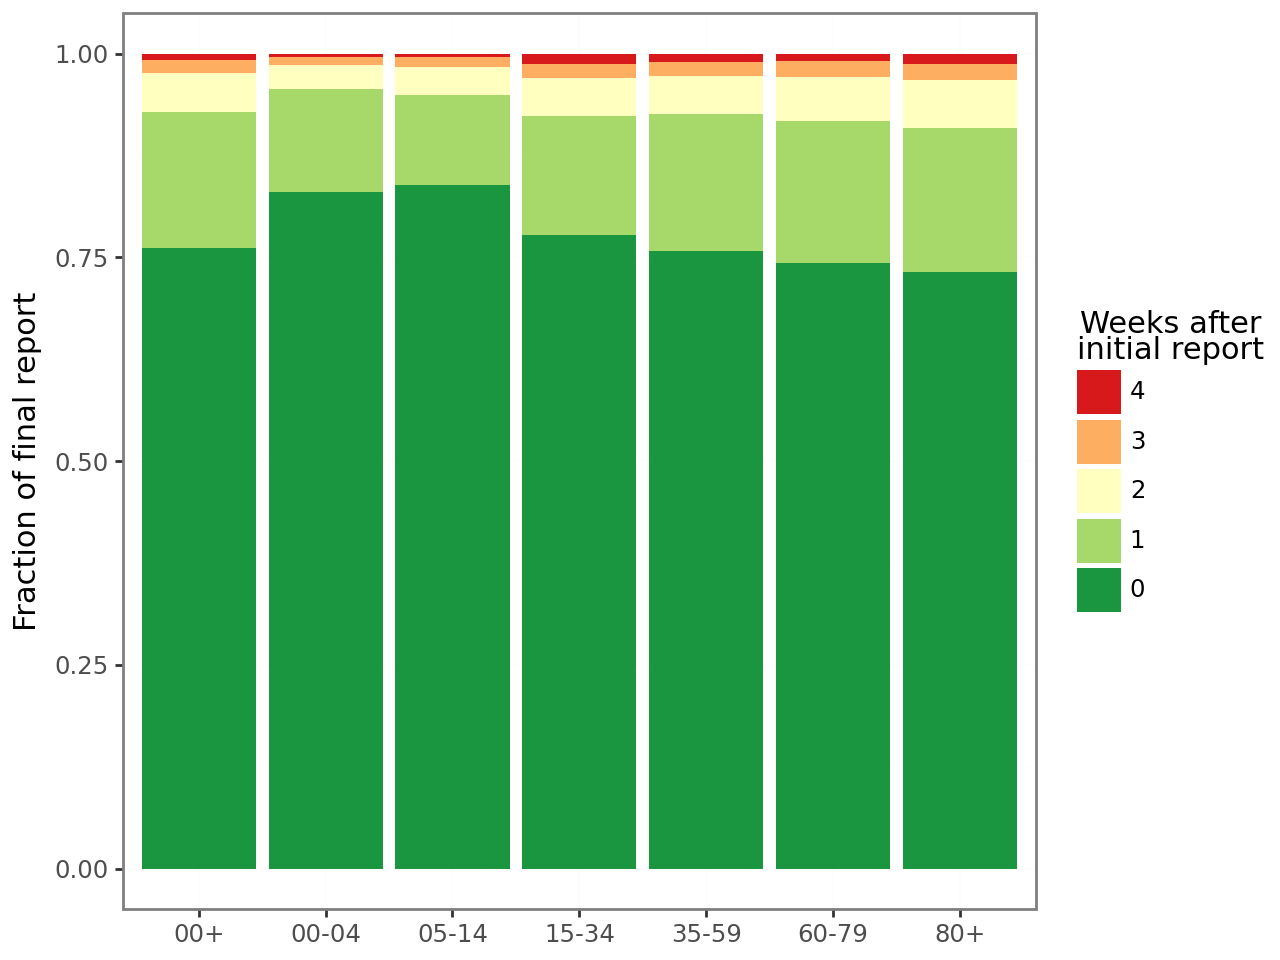

In [4]:
p.show()

In [ ]:
p.save(
    "../figures/fraction_age.pdf",
    width=150,
    height=80,
    units="mm",
    dpi=300,
    verbose=False,
)

### Over time

In [ ]:
def fraction_over_time(stratum=None):
    rt_sari = load_rt("sari", preprocessed=True)
    value_cols = [f"value_{d}w" for d in [0, 1, 2, 3, 4]]

    if stratum is None:
        df = rt_sari.copy()
        df.age_group = df.age_group.astype("category")
        df["age_group"] = df["age_group"].cat.reorder_categories(
            ["00-04", "05-14", "15-34", "35-59", "60-79", "80+", "00+"]
        )

    elif stratum == "national":
        df = rt_sari[rt_sari.age_group == "00+"]

    elif stratum == "age":
        df = rt_sari[rt_sari.age_group != "00+"]

    df.loc[:, value_cols] = df[value_cols].cumsum(axis=1)

    df = df.dropna()

    df[value_cols] = df[value_cols].apply(lambda x: x / df["value_4w"])

    df.loc[:, value_cols[1:]] = df[value_cols].diff(axis=1)[value_cols[1:]]

    df_melted = df.melt(
        id_vars=["location", "age_group", "date"],
        value_vars=value_cols,
        var_name="delay",
        value_name="value",
    )

    df_melted.delay = df_melted.delay.str[-2:-1]

    df_melted["delay"] = pd.Categorical(
        df_melted["delay"], categories=["4", "3", "2", "1", "0"], ordered=True
    )

    df_melted.date = pd.to_datetime(df_melted.date)

    return (
        ggplot(df_melted, aes(x="date", y="value", fill="delay", color="delay"))
        + facet_wrap("~age_group", scales="free" if stratum is None else "fixed")
        + geom_area(position="stack", alpha=1, size=0.3)
        + scale_color_brewer(type="div", palette="RdYlGn", guide=None)
        + scale_fill_brewer(type="div", palette="RdYlGn")
        + theme_bw()
        + labs(x="", y="Fraction of final report", fill="Weeks after\ninitial report")
        + scale_x_date(
            date_breaks="3 month", date_minor_breaks="1 month", date_labels="%b\n%Y"
        )
    )

In [ ]:
p1 = fraction_over_time("national")

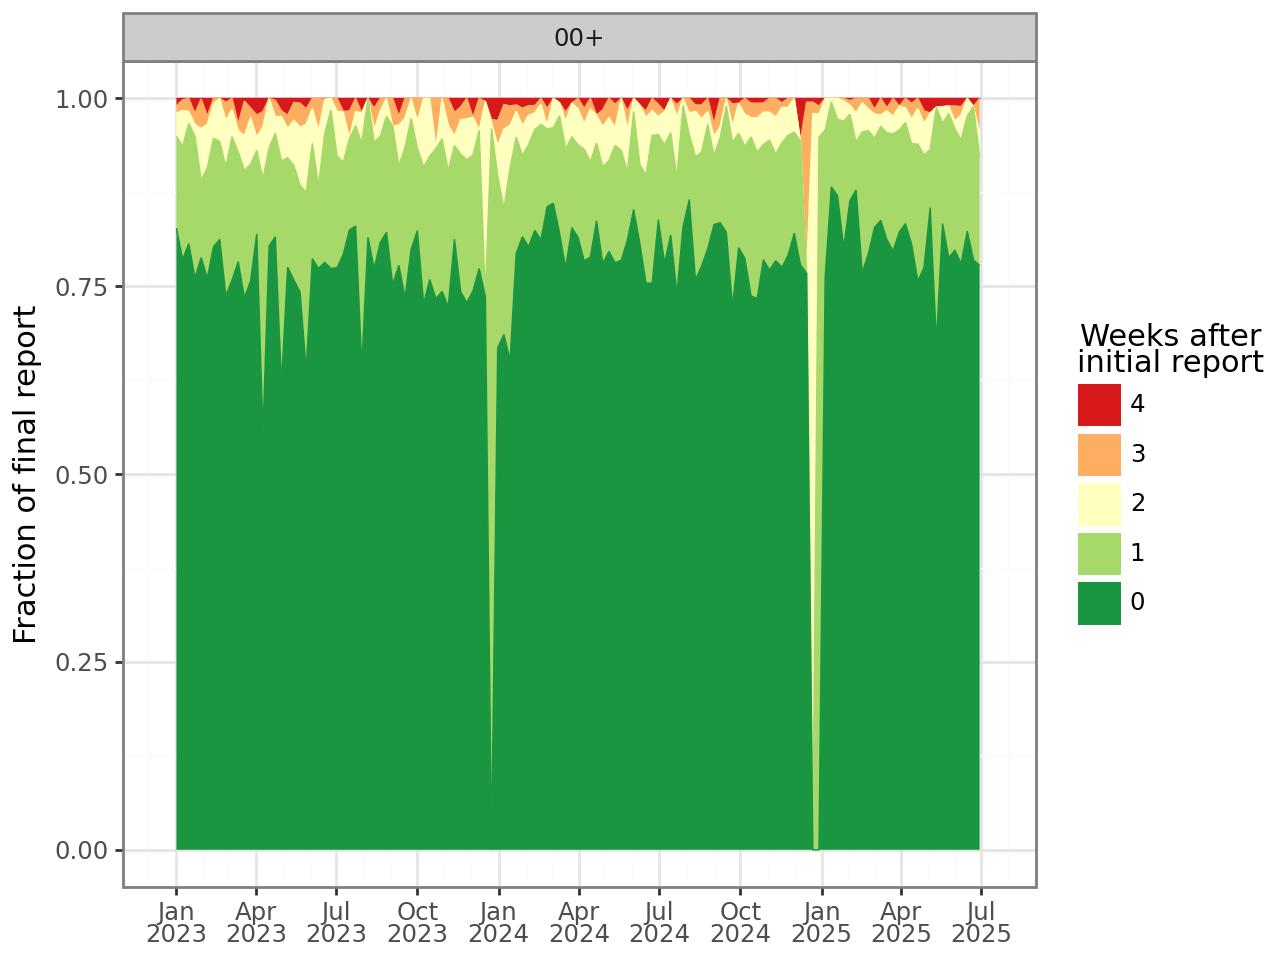

In [8]:
p1.show()

In [ ]:
p1.save(
    "../figures/fraction_national_time.pdf",
    width=150,
    height=80,
    units="mm",
    dpi=300,
    verbose=False,
)

In [ ]:
p2 = fraction_over_time("age")

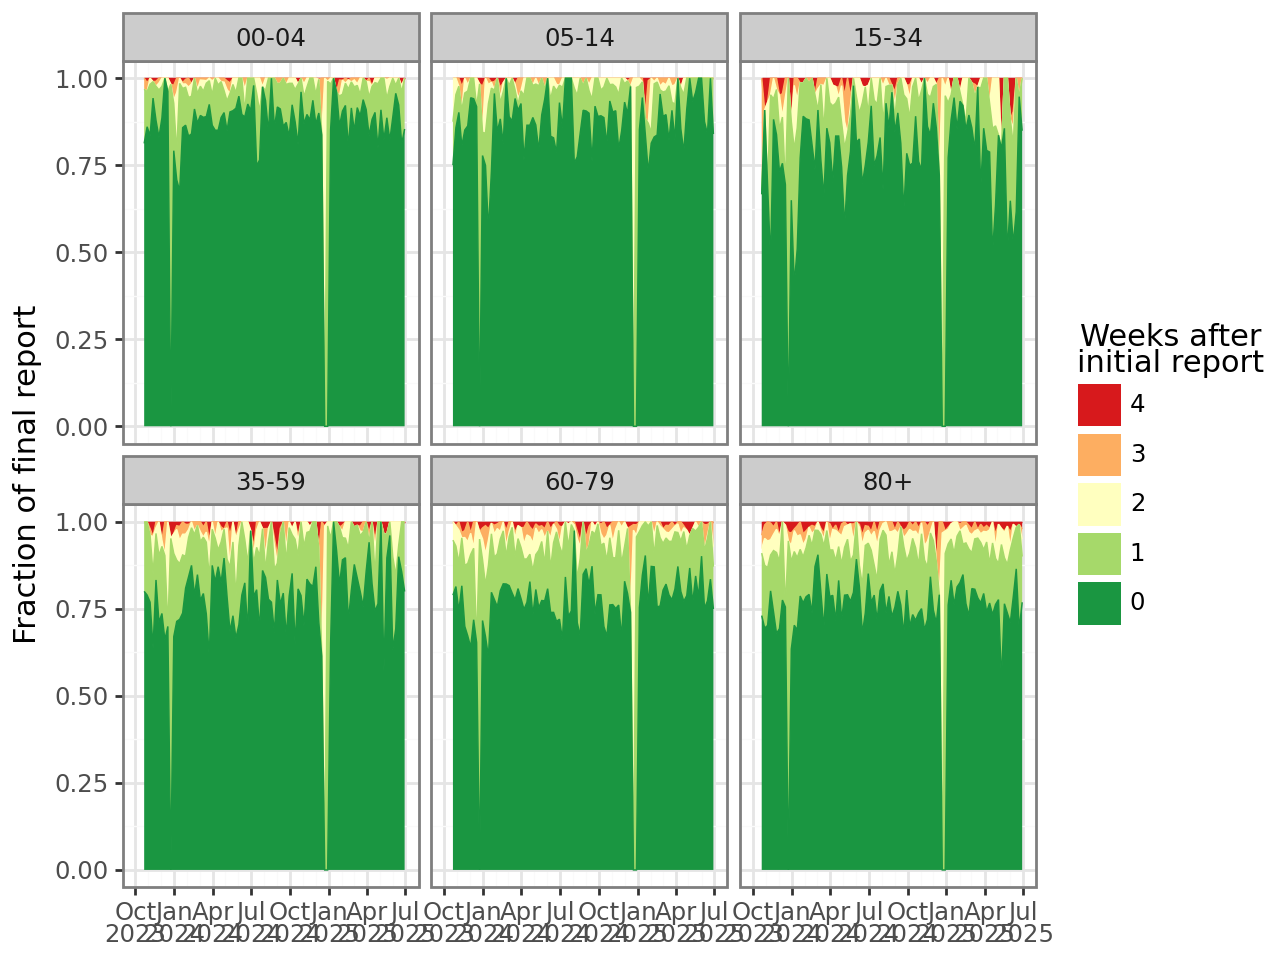

In [11]:
p2.show()

In [12]:
# p2.save("../figures/fraction_age_time.pdf", width=180, height=80, units="mm", dpi=300, verbose=False)

In [13]:
p3 = fraction_over_time()

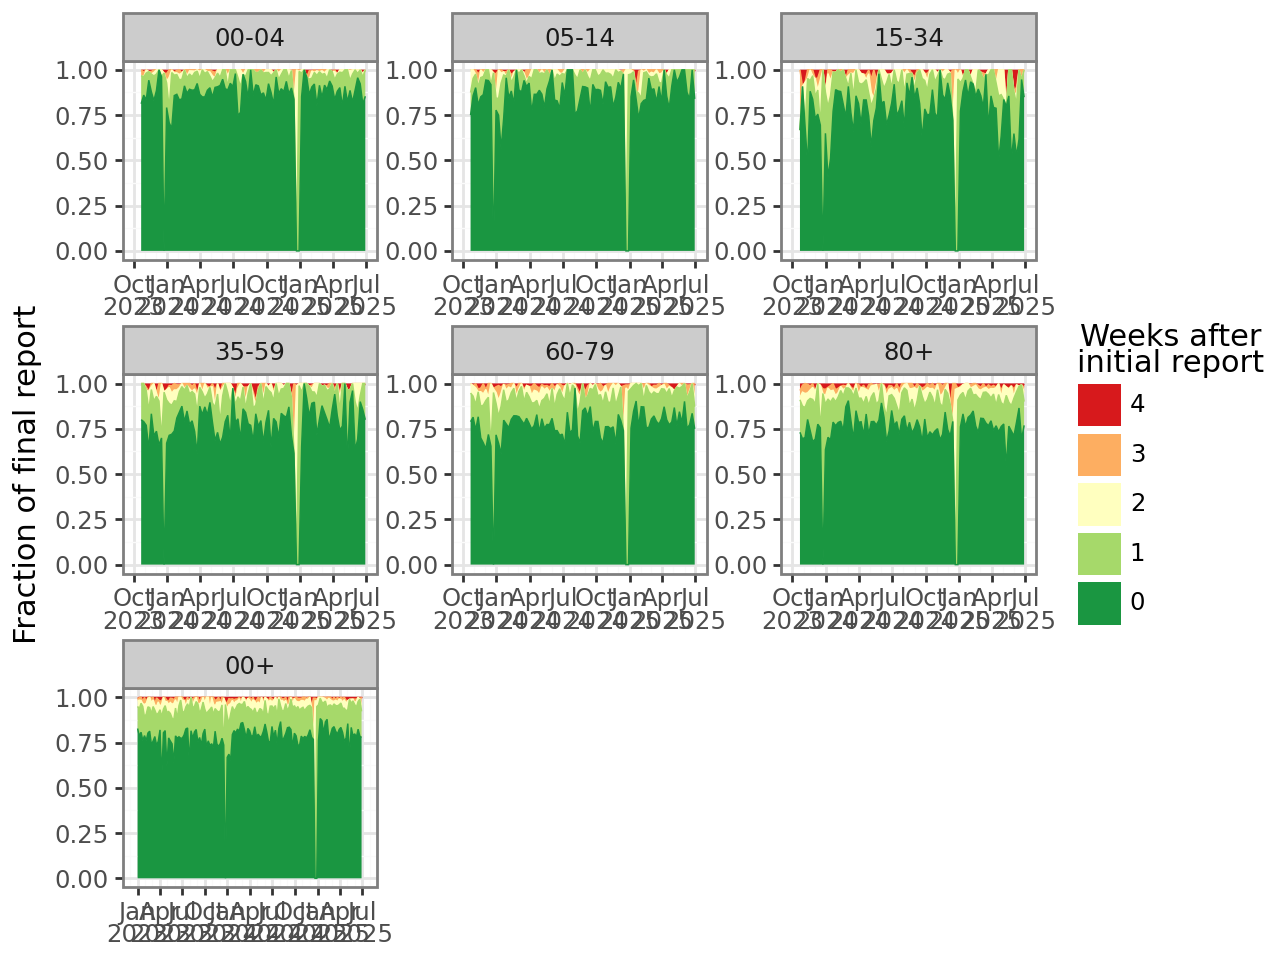

In [14]:
p3.show()

In [15]:
# p3.save("../figures/fraction_time.pdf", width=180, height=100, units="mm", dpi=300, verbose=False)